<a href="https://colab.research.google.com/github/sflyranger/multilabel_classification_nns/blob/main/sparse_embeddings_stack_posts_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'hotpink'>**Multi-label Classification: Sparse Embeddings**

#### <font color = 'hotpink'>*Using a multi layered perceptron for training*

- The primary difference between this notebook and the other is that I will be using TF-IDF sparse embeddings for the vocabulary instead of an embedding bag layer in the NN.
- TF-IDF embeddings do not require backpropogation to be calculated because thy are calculated prior to training based on document statistics.
- This means we will not need a collate function within the model.

### <font color = 'hotpink'>**Why we don't need a Collate Function:**
- The collate functions primary purpose is to pad or batch documents together of varying lengths into matrices and in the case of an EmbeddingBag calculate the offsets to indicate where documents begin within a given batch (long matrix - multiple documents).
- This allows us to calculate embeddings with within a smaller dimension than that of a sparse matrix (hence the name dense embeddings).
- When using TFIDF the matrices for the embeddings are preset based on Inverse Document Frequency (IDF - how rare a word is across documents.) and do not need to be learned during the training process.
- Since we do not need to learn the embeddings, we do not need an embedding bag layer, therefore we do not need a collate function to create new matrices to learn our embeddings.
- Not having to do this should speed up our training process within the perceptron.


## <font color = 'hotpink'>**Setting up the environment**

In [ ]:
import sys
if 'google.colab' in str(get_ipython()):  # If the code is running in Colab
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'

    # Installing the latest torchinfo library
    !pip install torchinfo -qq
    !pip install torchmetrics -qq
    !pip install -U nltk -qq # -U ensures the most updated version
    !pip install -U spacy -qq # -qq limits the output commands to only the most important messages
    !python -m spacy download en_core_web_sm -qq # Small model from spacy


    base_path = '/content/drive/MyDrive/Colab Notebooks' # set the base path to a Google Drive folder

    sys.path.append('/content/drive/MyDrive/Colab Notebooks/custom-functions')# enabling custom function usage

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# libraries for efficient serialization of python objects and for element tallying
from collections import Counter
import joblib

# filesystem libraries, generating and displaying confusion matrices, binarization for one-hot labels, data splitting, and date-time manipulations
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# custom dataset making from torch
from torch.utils.data import Dataset
# utility for gradient clipping
from torch.nn.utils import clip_grad_value_


# library to compute class weights
from sklearn.utils.class_weight import compute_class_weight

# general purpose libraries
import pandas as pd
import numpy as np
import random

# for working with textual data vocabularies and for displaying model summaries
from torchinfo import summary

# library for tensor computations and neural network modules
import torch
import torch.nn as nn

# libraries for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# printing library for formatted output of text
from pprint import pprint

# library for conversion of strings
import ast

# tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# HammingDistance is useful for evaluating multi-label classification problems.
from torchmetrics import HammingDistance

# library for iterations within rows
from itertools import combinations


# Import required stopwords
import nltk
from nltk.corpus import stopwords as nltk_stopwords  # Stopwords corpus
nltk.download('stopwords')  # Download the stopwords corpus

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix
# importing counter for class distributions
from collections import Counter




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Double checking path
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/content/drive/MyDrive/Colab Notebooks/custom-functions']

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Appending the data set path
base_folder = Path(base_path)
data_folder = base_folder/'datasets/stack_posts_ds'
model_folder = base_folder/'models/nlp_fall_2024/stack'

In [ ]:
# ensuring the model_folder is created in my drive
model_folder.mkdir(parents = True, exist_ok =True)

## <font color = 'hotpink'>**Loading the dataset**</font>

- This data set is a kaggle competition data set where the goal of the competition was to classify different questions from StackExchange users for different tech domains.
- Each post could mention multiple tech domains, hence why this model will be a multi-label classification task.
- The goal here will be to use a dense embedding layer within my NN to classify and understand the difference between dense and sparse embeddings for classification and their benefits.
- Overall, the layers within the entire model will consist of the following within a Simple Multi Layer Perceptron:
  - **Linear Layer 1**
  - **Hidden layer 1**
  - **ReLu**
  - **Dropout layer 1**
  - **BatchNorm layer 1**
  - **Linear Layer 2**
  - **Hidden Layer 2**
  - **ReLu**
  - **Dropout Layer 2**
  - **BatchNorm Layer 2**
  - **Output layer**

- The hyperparameters that will be used to fine-tune the model are as follows:
  - **Neurons for the first hidden layer**: 200
  - **Neurons for the second hidden layer**: 100
  - **Embedding Dimension**: 300
  - **EPOCHS**: 5
  - **BATCH_SIZE**: 128
  - **LEARNING_RATE**: 0.001
  - **WEIGHT_DECAY**: 0.000
  - **CLIP_TYPE**: 'value'
  - **PATIENCE**: 5
  - **Optimizer**: AdamW

- I will also be doing some gradient clipping and using the **Hamming Loss** as a metric, which I defined in other notebooks.

### <font color = 'hotpink'>*Data Pulled From Prior Notebook*
- I will be loading the data from some files stored on my drive from the dense embeddings NN notebook.
- The data was one-hot encoded and split with 60% training, 20% validation, 20% testing.


In [ ]:
# Defining filepath for training data set
train_clean_file = data_folder/'train_clean.pkl'

# filepath for cleaned validation data
valid_clean_file = data_folder/'valid_clean.pkl'

# filepath for the testin data set
test_clean_file = data_folder/'test_clean.pkl'


In [ ]:
# Reloading the different splits
X_train, y_train = joblib.load(train_clean_file)

X_val, y_val = joblib.load(valid_clean_file)

X_test, y_test = joblib.load(test_clean_file)

In [ ]:
print(f"X_train size: {len(X_train)}, y_train size: {len(y_train)}")
print(f"X_val size: {len(X_val)}, y_val size: {len(y_val)}")
print(f"X_test size: {len(X_test)}, y_test size: {len(y_test)}")


X_train size: 30352, y_train size: 30352
X_val size: 7589, y_val size: 7589
X_test size: 9486, y_test size: 9486


In [ ]:
X_train.head()

,cleaned_text
38601,nullpointerexception run figure return error h...
47089,display message press button need display mess...
9397,jquery javascript nan addition number attempt ...
46311,c#/asp.net helper library go to start build sm...
22026,replace link button label check box repeater g...


In [ ]:
y_train.head()

,0,1,2,3,4,5,6,7,8,9
38601,0,1,0,0,1,0,0,0,0,0
47089,0,0,0,1,0,1,0,0,0,0
9397,0,0,0,1,0,1,0,0,0,0
46311,1,0,0,0,0,0,0,0,0,1
22026,1,0,0,0,0,0,0,0,0,1


Looks good.

## <font color = 'hotpink'>**Checking the value counts of the training data set to apply weights to handle class imbalance.**

- In my other notebook I noticed the class imbalance present within the dataset so I am recalculating the same weights here to help with this issue in the Binary Cross Entropy Loss function.

In [ ]:
# summing across all rows to get the number of occurances
class_counts = np.sum(y_train, axis = 0)

total_samples = y_train.shape[0] # first index value is the number of samples

class_weights = total_samples/(len(class_counts)*class_counts)

class_weights = torch.tensor(class_weights, dtype=torch.float32)

print(class_counts)
print(total_samples)
print(class_weights)

0     6682
1     5321
2     3701
3    17541
4     4875
5    16010
6      479
7      351
8      192
9     7963
dtype: int64
30352
tensor([ 0.4542,  0.5704,  0.8201,  0.1730,  0.6226,  0.1896,  6.3365,  8.6473,
        15.8083,  0.3812])


In [ ]:
y_train.shape


(30352, 10)

In [ ]:
X_train.shape

(30352,)

# <font color = 'hotpink'>**TF-IDF Vectorization**
- As mentioned above I will be using the TF-IDF vectorization to convert the raw text within the documents into vectors.
- This process will create sparse embeddings for the features to be inplemented in the model.

###<font color = 'hotpink'>**Data Leakage Prevention**
- I will be performing the vectorization fit-transform process only on the training set.
- Then based on the fit of the vectorizer on the training set I will be transforming the validation and testing sets.
- Each of these sets will be zipped together into custom datasets with their respective dependent targets.

In [ ]:
# Fit-transforming the training set
tfidf = TfidfVectorizer(max_features = 5000)
X_train = tfidf.fit_transform(X_train)

# Transforming the validation and testing sets on the fitted vectorizer
X_val= tfidf.transform(X_val)
X_test= tfidf.transform(X_test)

# Converting the dependent variables to np.array formal
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
X_train

<30352x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1127572 stored elements in Compressed Sparse Row format>

In [ ]:
X_val

<7589x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 282364 stored elements in Compressed Sparse Row format>

In [ ]:
X_test

<9486x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 349738 stored elements in Compressed Sparse Row format>

In [ ]:
y_train.shape

(30352, 10)

In [ ]:
y_val.shape

(7589, 10)

In [ ]:
y_test.shape

(9486, 10)

<font color = 'hotpink'>**The arrays above are sparse matrix values ready to be plugged into the custom data set class below**

# <font color = 'hotpink'>**Defining a class for a custom dataset**

In [ ]:

class SparseCustomDataset(Dataset):
    def __init__(self, X, y):
        """
        X: Sparse matrix (TF-IDF vectors of documents)
        y: One-hot encoded labels (document categories)
        """
        self.X = X  # Keep sparse matrix in original format
        self.y = torch.tensor(y, dtype=torch.float32)  # Convert labels to tensors

    def __len__(self):
        return self.X.shape[0]  # Number of documents

    def __getitem__(self, idx):
        # Fetch sparse row (document TF-IDF vector) and convert to dense
        sparse_row = self.X[idx].toarray()  # Convert the sparse row to a dense array
        feature_tensor = torch.tensor(sparse_row, dtype=torch.float32).squeeze()

        # Get corresponding label (document category)
        label = self.y[idx]


        # Getting the feature and label tuple
        return feature_tensor, label


In [ ]:
# creating the different instances of of the CustomDataset class for modeling
trainset = SparseCustomDataset(X_train, y_train)

validset = SparseCustomDataset(X_val, y_val)

testset = SparseCustomDataset(X_test, y_test)



### <font color = 'hotpink'>**Printing out one of the samples**

In [ ]:
pprint(trainset[5]) #pulling the whole tuple
print()
sixth_sample_text = trainset[5][1] # pulling just the label
pprint(sixth_sample_text)
type(sixth_sample_text)

(tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]))

tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])


torch.Tensor

In [ ]:
sixth_sample_label = trainset[5][0]
pprint(sixth_sample_label) #printing just the feature tensor

tensor([0., 0., 0.,  ..., 0., 0., 0.])


# <font color='hotpink'>**CustomBlock class for usage in nn.Sequential Modeling**</font>

- This class gives me the flexibility to call multiple layers using **<font color='hotpink'>`nn.Sequential`</font>** and integrate those blocks into more complex models.
- Learning how to use these custom blocks within large-scale models improves **readability** and helps **scale models quickly**.
- The block takes **<font color='hotpink'>`nn.Sequential`</font>** as a layer, which can house multiple layers inside, like the ones I manually coded above. This allows me to efficiently organize and compile my code.
- The class is versatile—it can be **augmented** to include different layers within the custom block, providing even more flexibility when scaling or adjusting the model for various tasks.



In [ ]:
class CustomBlock(nn.Module):
    def __init__(self, input_dim, output_dim, drop_prob):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(num_features=output_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
        )

    def forward(self, x):
        return self.layers(x)

## <font color='hotpink'>**Custom MLP Model Architecture**</font>

### <font color='hotpink'>Model Overview:</font>
This MLP model is set up for multi-label classification and works with dense inputs like TF-IDF vectors. It’s built using two custom blocks, each packed with a fully connected layer, ReLU activation, batch normalization, and dropout. The final layer gives us the logits, which we'll use for the multi-label classification task.

### <font color='hotpink'>Key Components:</font>
1. **Custom Blocks**:
    - Each block contains:
        - A fully connected layer that takes the input dimension and converts it to the output dimension.
        - A ReLU activation function to add some non-linearity.
        - Batch normalization to keep things stable and speed up training.
        - Dropout to help regularize and prevent overfitting.

2. **Sequential Layering**:
    - The model is laid out sequentially for readability and clarity in how the layers flow.
    - Each custom block processes the input features, and the final linear layer spits out the logits we need for classification.

### <font color='hotpink'>Key Highlights:</font>
- **Input Dimension**: This refers to the number of input features, like the number of terms in a TF-IDF vector (e.g., 5000).
- **Hidden Layers**: Two hidden layers using custom blocks with batch normalization and dropout built-in.
- **Output Layer**: A fully connected layer that provides the logits for our classification task across all the classes.
- **Device Compatibility**: The model checks that your input tensor and model parameters are on the same device (CPU or GPU) to avoid any mismatches.

### <font color='hotpink'>Forward Pass:</font>
- The input tensor goes through the layers in sequence, and the final output is the predicted logits for multi-label classification.


In [ ]:
class CustomMLP(nn.Module):
  def __init__(self,input_dim,hidden_dim1,hidden_dim2, drop_prob1,drop_prob2, num_outputs):
    super().__init__()

    # Defining what a layer is going to be.
    # This layer is a sequential layer that houses multiple layers
    # This is much easier to read and understand.
    # Each custom block houses the input dimension and plugs it into the output by passing it through the CustomBlock where the ReLU,BatchNorm and Dropout layers are housed.
    self.layers = nn.Sequential(
        CustomBlock(input_dim, hidden_dim1, drop_prob1),
        CustomBlock(hidden_dim1, hidden_dim2, drop_prob2),
        nn.Linear(hidden_dim2, num_outputs)
    )


  def forward(self, x):


      # Ensure inputs are on the same device as the model
      assert x.device == next(self.parameters()).device, "Data not on the same device as model"

      # passing the embedding layer into the layers function where all other layers are housed.
      out = self.layers(x)

      return out

### <font color = 'hotpink'>**Testing the Custom MLP**


In [ ]:
!pip install torchviz
!pip install Ipython

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=18aa901d498eca75887f244868929063ef19ebcd0691427573a27987298af6fc
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
# Defining my device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Defining the model
# Using a vocab_size of 5000 as the input_dim, since we are using TF-IDF vectors with 5000 features
model = CustomMLP(input_dim=5000, hidden_dim1=5, hidden_dim2=5, drop_prob1=0.5, drop_prob2=0.3, num_outputs=10)

# Pushing the model to the device
model = model.to(device)

# Display the model summary
summary(model, input_size=(1, 5000), device=device)


Layer (type:depth-idx)                   Output Shape              Param #
CustomMLP                                [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─CustomBlock: 2-1                  [1, 5]                    --
│    │    └─Sequential: 3-1              [1, 5]                    25,015
│    └─CustomBlock: 2-2                  [1, 5]                    --
│    │    └─Sequential: 3-2              [1, 5]                    40
│    └─Linear: 2-3                       [1, 10]                   60
Total params: 25,115
Trainable params: 25,115
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.12

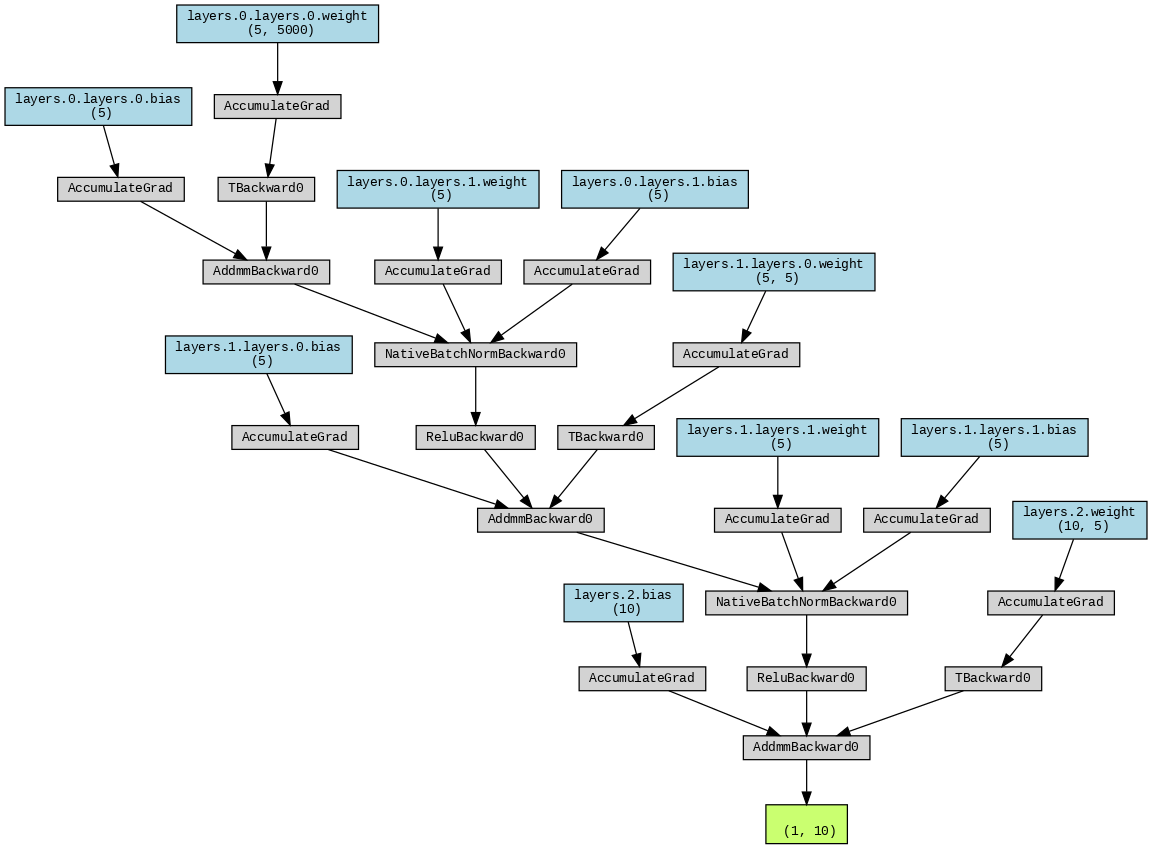

In [ ]:
from torchviz import make_dot
from IPython.display import Image

model.eval()
# Create some fake TF-IDF data (assuming 5000 features)
fake_input = torch.randn(1, 5000, dtype=torch.float32).to(device)  # A single document TF-IDF vector

# Pass the input directly to the model
output = model(fake_input)

# Create the graph visualization
diagram = make_dot(output, params=dict(model.named_parameters()))
diagram.render('CustomMLP_test', format='png')

# Display the image
Image(filename='CustomMLP_test.png')

In [ ]:
print(output)

tensor([[-0.2155, -0.3458,  0.2140, -0.0879,  0.0273, -0.3914, -0.4914, -0.0859,
         -0.2165,  0.1275]], device='cuda:0', grad_fn=<AddmmBackward0>)


# <font color = 'hotpink'>**Step function**

In [ ]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):

    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - labels (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """


    # Move the model and data to the device
    model = model.to(device)

    inputs = inputs.to(device)

    targets = targets.to(device).float() # Ensuring the labels are passed as float for the BCE loss function

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate the number of correctly classified samples
    predicted = (outputs > 0.5).float()

    # Step 2c: Calculating and updating the hamming distance
    hamming_distance_metric = HammingDistance(task = 'multilabel', num_labels = targets.size(1)).to(device)
    hamming_distance = hamming_distance_metric(predicted, targets).item()



    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad() # Zero gradients
        loss.backward() # Backward pass
        clip_grad_value_(model.parameters(),clip_value = 10) # Gradient clipping to prevent exploding gradients
        optimizer.step() # updating params

    # Return relevant metrics
    if loss_function:
        return loss, outputs, hamming_distance
    else:
        return None, outputs, hamming_distance

# <font color = 'hotpink'>**Train_epoch function**
- Step function implemented in the epoch training phase.
- updates the hamming distance and loss for each batch within the epoch.
- takes the average hamming distance and train_loss for that epoch of batches.

In [ ]:
def train_epoch(train_loader, model, device, loss_function,optimizer):
  """
  Trains the model for one epoch using the provided data loader and updates the model parameters.

  Parameters:
  -train_loader (torch.utils.data.DataLoader): dataloader object for the training dataset
  -model (torch.nn.Module): Neural network model to be trained.
  - device (torch.device): The CPU or GPU
  -loss_function: function used to compute the training loss.
  -optimizer: The function to minimize the loss during training by updating model parameters.

  Returns:
  -train_loss (float): Average Training Loss for the epoch.
  -avg_ hamming_distance (float): Training Hamming Distance average for the Epoch.
  """

  # Setting the model to training mode
  model.train()

  # Initializing the variables to track the training loss and correct predictions.
  running_train_loss = 0.0
  running_hamming_distance = 0.0

  # Iterating over all batches
  for inputs, targets in train_loader:
    # Performing the forward and backward pass and updating parameters
    loss,outputs, hamming_distance = step(inputs,targets,model,device,loss_function,optimizer)

    # Updating the running loss and the Hamming Distance
    # adds the training loss from the batch
    running_train_loss += loss.item()
    # adds the hamming distance from the batch
    running_hamming_distance += hamming_distance

  # this calculates the average train loss and hamming distance within the epoch.
  train_loss = running_train_loss/len(train_loader)
  avg_hamming_distance = running_hamming_distance / len(train_loader)

  return train_loss, avg_hamming_distance

## <font color = 'hotpink'>**Creating the validate epoch function (val_epoch):**


In [ ]:
def val_epoch(valid_loader,model,device,loss_function):
  """
  Validates the model for one epoch using the provided data loader.


  Parameters:
  - valid_loader (torch.utils.data.DataLoader): Dataloader object for the validation set.
  - model (torch.nn.Module): Neural Network model to be trained
  - device (torch.device): The computing device CPU or GPU.
  - loss_function (torch.nn.Module): Loss function to be used during training.

  Returns:
  - val_loss (float): The validation set loss for the epoch.
  - val_hamming distance (float): Validation Hamming Distance for the epoch.
  """
  # swiching the model to evaluation mode
  model.eval()

  # initiaizing the running validation loss and hamming distance
  running_val_loss = 0.0
  running_hamming_distance = 0.0

  # disabling the gradient to prevent leakage of information and speed up the training process.
  with torch.no_grad():

    # iterating over each batch in the loader.
    for inputs, targets in valid_loader:

      # forward pass for hamming distance:
      loss, outputs, hamming_distance = step(inputs, targets, model, device, loss_function, optimizer = None)

      # Updating the running loss and hamming distance
      running_val_loss += loss.item()
      running_hamming_distance += hamming_distance

  # average validation loss of the epoch
  val_loss = running_val_loss/len(valid_loader)
  # average hamming distance of the epoch
  avg_val_hamming_distance = running_hamming_distance/len(valid_loader)

  return val_loss, avg_val_hamming_distance




# <font color='hotpink'>**Early Stopping Mechanism**</font>

- **Early Stopping** is a regularization technique that helps prevent **overfitting** by monitoring the **validation loss** during training.
- The idea is simple: if the **validation loss** doesn't improve for a set number of epochs (determined by **<font color='hotpink'>patience</font>**), training will stop early, saving time and preventing the model from overfitting to the training data.
- The **<font color='hotpink'>`patience`</font>** parameter controls how many epochs we are willing to wait for improvement, and the **<font color='hotpink'>`delta`</font>** parameter defines the minimum improvement in validation loss required to reset the patience counter.
- The **<font color='hotpink'>`restore_best_weights`</font>** parameter gives the ability to apply the best weights from the stat_dict of the model should early stopping be called. This parameter only activates when **<font color='hotpink'>`restore_best_weights = True`</font>**
- This function is essential for ensuring our model generalizes well to unseen data and stops training when no further improvement is observed.


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, restore_best_weights = False):
        """
        Initializes the EarlyStopping object to track validation loss and stop training if no improvement.

        Parameters:
        - patience (int): Number of epochs with no improvement after which training will be stopped.
        - delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience          # How many epochs to wait before stopping
        self.delta = delta                # Minimum improvement required
        self.best_loss = float('inf')     # Initialize best loss as infinity
        self.counter = 0                  # Counter for how many epochs since improvement
        self.early_stop = False           # Flag for whether to stop early
        self.restore_best_weights = restore_best_weights # A setting to pull out the best weights
        self.best_weights = None          # Used to store the best weights when restore_best_weights = True

    def __call__(self, val_loss, model = None):
        """
        Check whether the validation loss has improved sufficiently. If not, increase the counter.
        If the counter reaches the patience, set the early_stop flag to True.

        Parameters:
        - val_loss (float): The current validation loss to be compared against the best loss.
        """
        # If the validation loss improves by more than delta
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss     # Update best loss
            self.counter = 0              # Reset the counter
        else:
            # No improvement, increment the counter
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True     # Set the early stopping flag
                if self.restore_best_weights and model is not None:
                  model.load_state_dict(self.best_weights) # Restoring the best weights after early stopping


## <font color = 'hotpink'>**Train function for full dataset**


In [ ]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience):
  """
  Trains and validates the model, and returns history of train and validation metrics.

  Parameters:
  - train_loader(torch.utils.data.DataLoader): The defined training dataset loader.
  - valid_loader(torch.utils.data.DataLoader): The defined validation dataset loader.
  - model(torch.nn.Module): The Neural Network we want to train.
  - optimizer (torch.optim.Optimizer): The defined optimizer to update model weights.
  - loss_function (torch.nn.Module): The defined loss function to evaluate the model.
  - epochs: the number of epochs to train the model on the full dataset.
  - device (torch.device): The defined device CPU or GPU

  Returns:
  - train_loss_history (list): History of training loss for each epoch.
  - train_hamming_history (list): History of training hamming distance for each epoch.
  - valid_loss_history (list): History of validation loss for each epoch.
  - valid_hamming_history (list): History of validation hamming distance for each epoch.
    """
  train_loss_history = []
  train_hamming_history = []
  valid_loss_history = []
  valid_hamming_history = []

  # inititializing early stopping
  early_stopping = EarlyStopping(patience = patience)

  # Iterating the train_epoch and val_epoch functions over every epoch
  for epoch in range(epochs):
    train_loss, avg_train_hamming_distance = train_epoch(
        train_loader, model, device, loss_function, optimizer)

    val_loss, avg_valid_hamming_distance = val_epoch(
        valid_loader, model, device, loss_function
    )

    # appending the losses and hamming distances to the histories
    train_loss_history.append(train_loss)
    train_hamming_history.append(avg_train_hamming_distance)
    valid_loss_history.append(val_loss)
    valid_hamming_history.append(avg_valid_hamming_distance)

    # epoch level summaries
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train loss:{train_loss:.4f} | Train Hamming Distance: {avg_train_hamming_distance}')
    print(f'Validation loss: {val_loss:.4f} | Validation Hamming Distance:{avg_valid_hamming_distance}')
    print()

    # Early stopping check
    early_stopping(val_loss, model)

    # Break the loop if early stopping is triggered
    if early_stopping.early_stop:
      print('Early stopping triggered')
      break


  return train_loss_history, train_hamming_history, valid_loss_history, valid_hamming_history


# <font color = 'hotpink'>**Training the Model**

## <font color = 'hotpink'>**Hyperparameters**
- The hyperparameters that will be used to fine-tune the model are as follows:
  - **Neurons for the first hidden layer**: 200
  - **Neurons for the second hidden layer**: 100
  - **Embedding Dimension**: 300
  - **EPOCHS**: 5
  - **BATCH_SIZE**: 128
  - **LEARNING_RATE**: 0.001
  - **WEIGHT_DECAY**: 0.000
  - **CLIP_TYPE**: 'value'
  - **PATIENCE**: 5
  - **Optimizer**: AdamW

In [ ]:
X_train.shape

(30352, 5000)

In [ ]:
# model parameters
INPUT_DIM = X_train.shape[1]
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS=10
PATIENCE= 5


# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.000

## <font color = 'hotpink'>**Training Configurations**

In [ ]:
# Fixing the seed values for reproducibility
SEED = 1717
random.seed(SEED)                           # Sets the seed for the random module
np.random.seed(SEED)                        # Sets the seed for the np.random module for number generation
torch.manual_seed(SEED)                     # Sets the seed for PyTorch CPU
torch.cuda.manual_seed(SEED)                 # Sets the seed for the PyTorch GPU
torch.backends.cudnn.deterministic = True   # Ensures the deterministic behavior in CuDNN

# Defining the device for model training (Cuda T4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Collate function removed

# Data Loaders for the train, valid and test sets
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True,
                                            num_workers = 2) # num_workers allows for cpu cores to handle some processing while the model trains on the GPU

valid_loader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True,
                                          num_workers = 2)

test_loader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True,
                                          num_workers = 2)
# Move class weights to the correct device
class_weights = class_weights.to(device)

# defining the loss function and applying class weights
loss_function = nn.BCEWithLogitsLoss(pos_weight = class_weights)

# Defining the model with the parameters
model_sparse_stack = CustomMLP(
                        input_dim = INPUT_DIM,
                        hidden_dim1 = HIDDEN_DIM1,
                        hidden_dim2 = HIDDEN_DIM2,
                        drop_prob1 = DROP_PROB1,
                        drop_prob2 = DROP_PROB2,
                        num_outputs = NUM_OUTPUTS)

# initializing the optimizer to train the model
optimizer = torch.optim.AdamW(model_sparse_stack.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

# Make sure the model is on the correct device
model_sparse_stack = model_sparse_stack.to(device)


### <font color = 'hotpink'>**Checkpoints**

In [ ]:
print(f"Model device: {next(model_sparse_stack.parameters()).device}")
print(f"Inputs device: {inputs.to(device)}")
print(f"Targets device: {targets.device}")

Model device: cuda:0
Inputs device: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
Targets device: cuda:0


In [ ]:
print(f"Output shape: {outputs.shape}")
print(f"Targets shape: {targets.shape}")


Output shape: torch.Size([128, 10])
Targets shape: torch.Size([128, 10])


In [ ]:
# Check if there are NaNs in the outputs or targets
print(torch.isnan(outputs).any())  # Should print False
print(torch.isnan(targets).any())  # Should print False


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


In [ ]:
# Check for any non-binary values in the targets
print(torch.unique(targets))


tensor([0., 1.], device='cuda:0')


In [ ]:
print(f"Inputs shape before passing to the model: {inputs.shape}")


Inputs shape before passing to the model: torch.Size([128, 5000])


## <font color='hotpink'>**Sanity Check for Multi-Label Classification**</font>

Before diving into full-scale training, it's always a good idea to run a **sanity check**. This quick check ensures that both the data processing and the model's forward pass are working as expected. For our multi-label classification setup, we can compare the actual loss from an untrained model to the **theoretical loss** for random predictions.

- Since we're using **`BCEWithLogitsLoss`**, which combines the sigmoid function and binary cross-entropy, the expected **theoretical loss** for random predictions should be close to **`log(2)`** (around 0.693). This is because a random guess for each label would yield about a 50% probability for being either 0 or 1.

- The process here involves running a single forward pass on a batch of data and computing the loss without any gradients. If the actual loss from the untrained model is close to **`log(2)`**, it suggests that our model architecture and data processing are set up correctly, and we’re ready to move forward.

This step helps catch any potential issues early on, so we don’t waste time training a model that has fundamental errors in its setup.


In [ ]:
# Running the DataLoader for the first batch to inspect the data
for inputs, targets in train_loader:
    # Print the shape and device of targets (labels)
    print(f"targets shape: {targets.shape}, targets device: {targets.device}")

    # Move the data to the appropriate device (GPU or CPU)
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Print again after moving to the device
    print(f"targets device after moving: {targets.device}")

    # Ensure all data is on the same device
    assert next(model_sparse_stack.parameters()).device == device, "Model not on the same device!"

    # Pass it through the model to ensure the forward pass works
    model_stack.eval()
    with torch.no_grad():
      outputs = model_sparse_stack(inputs)  # Forward pass with unpacked inputs
      loss = loss_function(outputs, targets)
      print(f'Actual loss: {loss.item()}')

      break
    # Print output shape and ensure it matches target shape
    print(f"Output shape: {output.shape}, Output device: {output.device}")
    print(f"Expected target shape: {targets.shape}")

    break  # Stop after the first batch for debugging purposes

targets shape: torch.Size([128, 10]), targets device: cpu
targets device after moving: cuda:0
Actual loss: 0.6448413133621216


The actual loss matches around what we would expect the theoretical loss to be from a random guess.

## <font color = 'hotpink'>**Training**

In [ ]:
# calling the training function for the model
train_losses, train_hamming,valid_losses, valid_hamming = train(
    train_loader, valid_loader, model_stack, optimizer,loss_function,EPOCHS,device, patience = PATIENCE
)

Epoch 1/5
Train loss:0.6441 | Train Hamming Distance: 0.31478466406589795
Validation loss: 0.6198 | Validation Hamming Distance:0.2230887532234192

Epoch 2/5
Train loss:0.6424 | Train Hamming Distance: 0.3138622669111781
Validation loss: 0.6220 | Validation Hamming Distance:0.22413041392962138

Epoch 3/5
Train loss:0.6437 | Train Hamming Distance: 0.314820772459527
Validation loss: 0.6212 | Validation Hamming Distance:0.22286528547604878

Epoch 4/5
Train loss:0.6439 | Train Hamming Distance: 0.3149619217680282
Validation loss: 0.6193 | Validation Hamming Distance:0.2226189434528351

Epoch 5/5
Train loss:0.6441 | Train Hamming Distance: 0.31489627100840334
Validation loss: 0.6206 | Validation Hamming Distance:0.22386683722337086



In [ ]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()

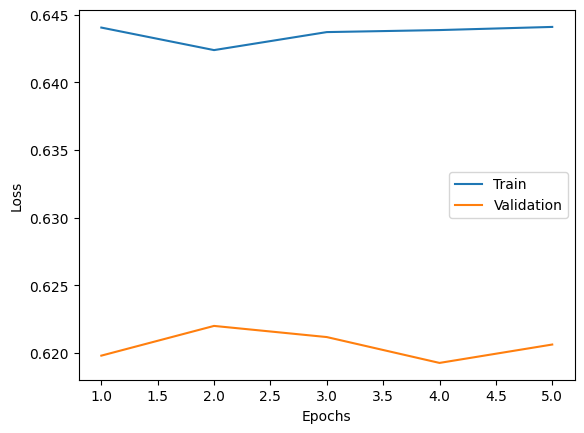

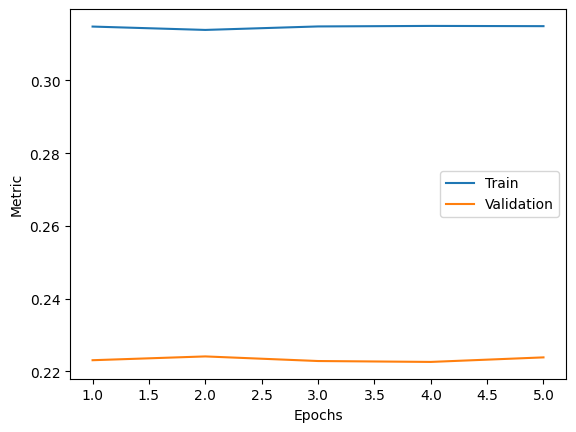

In [ ]:
plot_history(train_losses, train_hamming, valid_losses, valid_hamming)

# <font color='hotpink'>**Training Analysis**</font>

- Based on the results from the epoch outputs and the training plots, it is obvious this sparse model is not performing well or even improving over time, it is <font color = 'hotpink'>**underfitting.**</font>
- This is probably because the **TF-IDF embeddings** are <font color='hotpink'>pretrained and do not change or learn</font> within the layers of the model.
- In other words, it means that the <font color='hotpink'>sentiment and meaning</font> of the words within the **TF-IDF vector space** is not conducive to analyzing the **semantic meaning** within our specific set of documents.
- Based on my research, it seems like this is a common occurrence when attempting to classify documents based on content.
- Going forward, this will mark the point of me solidly understanding the <font color='hotpink'>difference</font> between using **pretrained embeddings** like TF-IDF versus **learnable embeddings**.
- We will still go through the rest of the model evaluation steps below.




**Checkpoint**

In [ ]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer_sparse'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/stack/2024-09-29_22-28-52_twolayer_sparse.pt')

In [ ]:
# Save the model's state dictionary to the specified file path
torch.save(model_stack.state_dict(), path)


In [ ]:

def get_hamming_distance_pred(data_loader, model, device):
    """
    Function to get predictions and Hamming distance for a given dataset using a trained model.
    Input: data iterator, model, device
    Output: predictions, actual labels, and Hamming distance for the given dataset.
    """
    model = model.to(device)
    model.eval()  # Set model to evaluation mode

    # Initialize empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Hamming distance metric (adjust num_labels to match your model's output size)
    hamming_metric = HammingDistance(task='multilabel', num_labels=NUM_OUTPUTS).to(device)

    running_hamming_distance = 0.0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over batches from data loader
        for inputs, targets in data_loader:  # The missing loop
            # Move inputs and targets to the device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass: get model predictions
            outputs = model(inputs)

            # Apply threshold to convert outputs to binary predictions (e.g., 0.5 threshold)
            predicted = (outputs > 0.5).float()

            # Concatenate predictions and targets for the full dataset
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets))

            # Compute Hamming distance for the current batch
            batch_hamming_distance = hamming_metric(predicted, targets).item()
            running_hamming_distance += batch_hamming_distance

    # Calculate average Hamming distance for the entire dataset
    avg_hamming_distance = running_hamming_distance / len(data_loader)

    return predictions, y, avg_hamming_distance


In [ ]:
predictions_valid, labels_valid, avg_hamming_distance = get_hamming_distance_pred(valid_loader, model_stack, device)
print(f"Average Hamming Distance on validation set: {avg_hamming_distance:.4f}")


Average Hamming Distance on validation set: 0.2237


### <font color='hotpink'>**Hamming Score on Validation**</font>
- Based on the average hamming distance of this model it is easy for me to see how much worse this model is performing than the dense embedding bag approach.
- The average hamming distance here equates to incorrectly selecting 22.3% of the labels.
- This an indicator that the model will not improve or generalize well with more data.


In [ ]:
predictions_valid.shape

torch.Size([7589, 10])

In [ ]:
labels_valid.shape

torch.Size([7589, 10])

In [ ]:
def plot_multilabel_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots multiple confusion matrices for each label in a multilabel classification task.

    Args:
        valid_labels (torch.Tensor): True labels of the validation data.
        valid_preds (torch.Tensor): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    num_classes = len(class_labels)

    # Create a 10x10 grid for confusion matrices
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust for 10 classes

    for i, ax in enumerate(axes.flat):
        if i >= num_classes:
            break

        # Compute the confusion matrix for the current class
        cm = confusion_matrix(valid_labels[:, i].cpu(), valid_preds[:, i].cpu())

        # Plot the confusion matrix using Seaborn
        sns.heatmap(cm, annot=True, fmt="d", cmap="PiYG", ax=ax, cbar=True)

        # Set labels and title for each subplot
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Confusion Matrix for {class_labels[i]}')

    plt.tight_layout()
    plt.show()

Average Hamming Distance on validation set: 0.2236


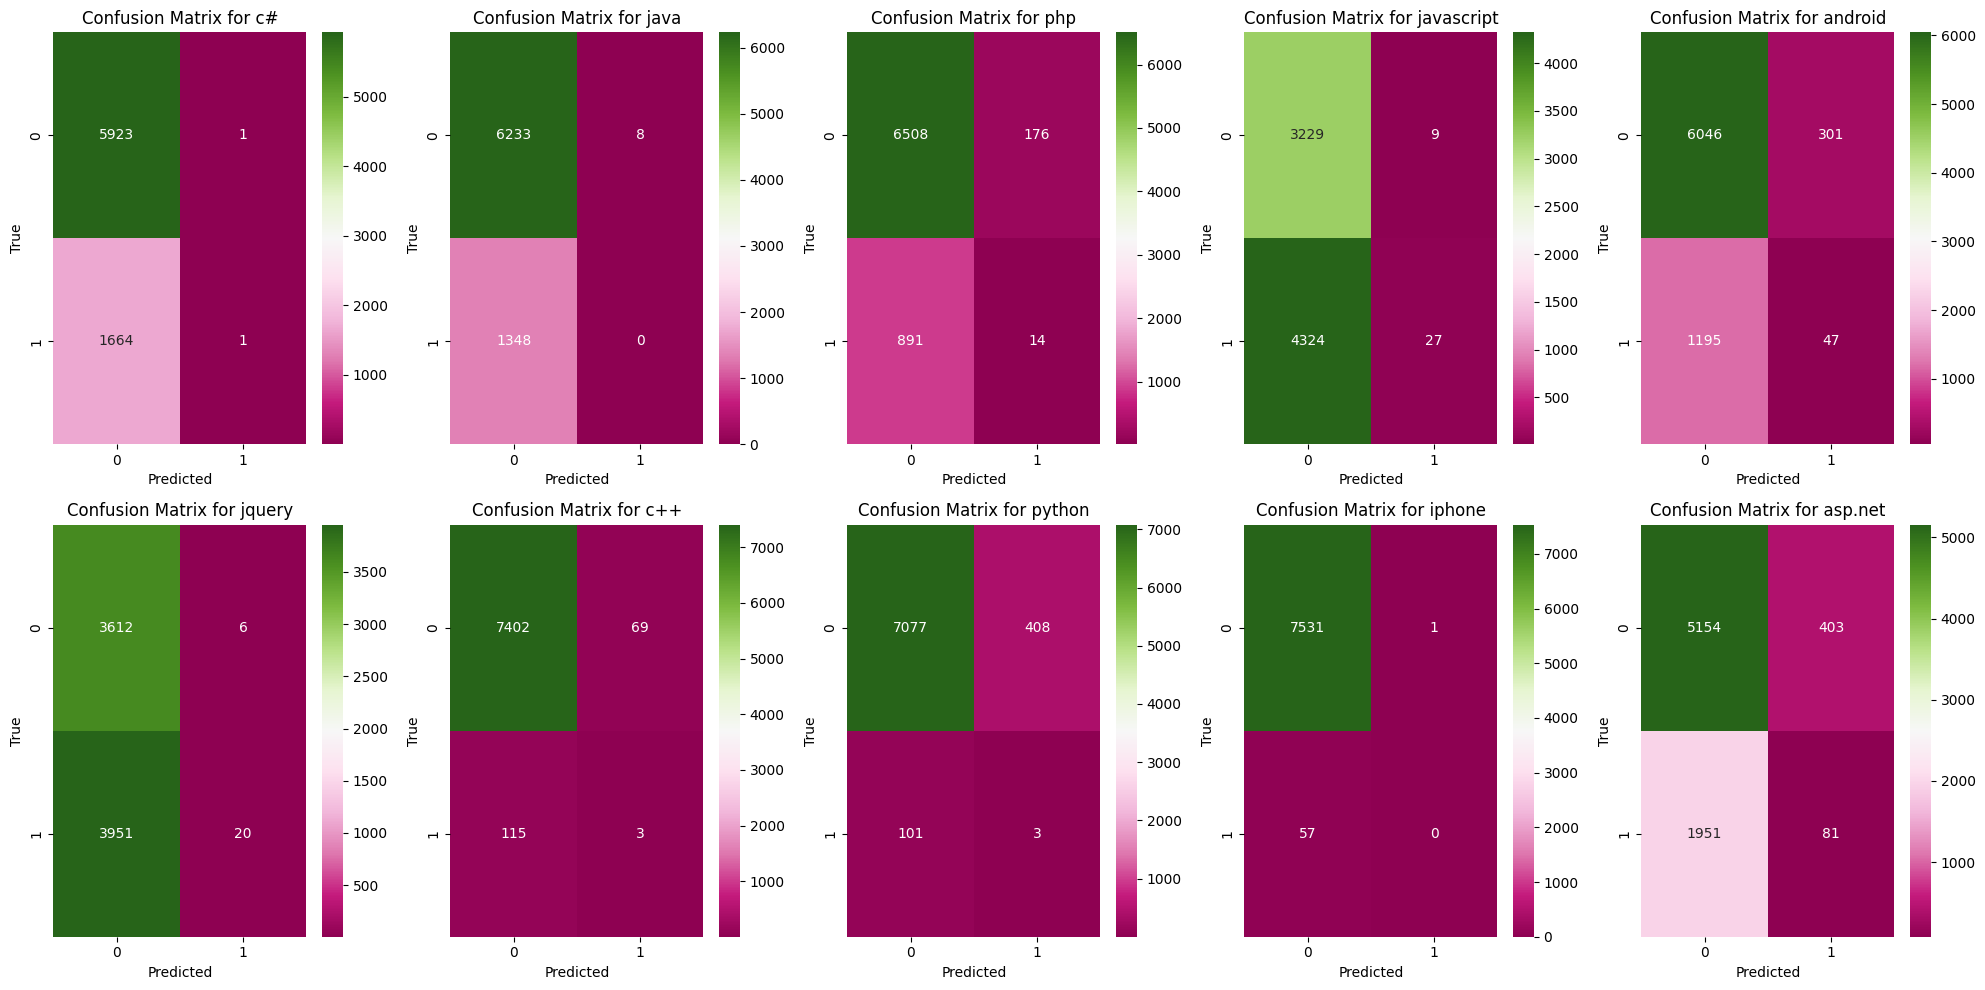

In [ ]:
# First, get the predictions and actual labels
predictions, y_true, avg_hamming_distance = get_hamming_distance_pred(valid_loader, model_stack, device)

print(f"Average Hamming Distance on validation set: {avg_hamming_distance:.4f}")

class_labels = ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net']


# Plot the confusion matrices
plot_multilabel_confusion_matrix(y_true, predictions, class_labels)


<

### <font color = 'hotpink'>**Confusion Matrix Analysis**

- The outputs here clearly show similar results to what has already been mentioned above.
- For the most part it seems that the model is just classifying many of the labels as negative (not having the label present).




# <font color = 'hotpink'>**Model Testing**


In [ ]:
trained_model_sparse_stack = CustomMLP(input_dim = INPUT_DIM,
                        hidden_dim1 = HIDDEN_DIM1,
                        hidden_dim2 = HIDDEN_DIM2,
                        drop_prob1 = DROP_PROB1,
                        drop_prob2 = DROP_PROB2,
                        num_outputs = NUM_OUTPUTS)

checkpoint = torch.load(path) # saving the model to a file and passing the weights to the checkpoint to make predictions.
trained_model_sparse_stack.load_state_dict(checkpoint)

<ipython-input-122-5d5d56e8baae>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path) # saving the model to a file and passing the weights to the c

<All keys matched successfully>

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred, class_labels):
    """
    Computes precision, recall, and F1 score for each class in a multilabel classification task.

    Args:
    - y_true: Ground truth labels (multilabel format).
    - y_pred: Predicted labels (multilabel format).
    - class_labels: List of class names.

    Returns:
    - result_table: A list of lists containing precision, recall, and F1 score for each class.
    """
    result_table = []

    for i, class_label in enumerate(class_labels):
        # Get true values and predicted values for the current class
        true_class = y_true[:, i].cpu().numpy()
        pred_class = y_pred[:, i].cpu().numpy()

        # Compute precision, recall, and F1 score
        precision = precision_score(true_class, pred_class, zero_division=1)
        recall = recall_score(true_class, pred_class, zero_division=1)
        f1 = f1_score(true_class, pred_class, zero_division=1)

        # Append the results for the current class
        result_table.append([class_label, precision, recall, f1])

    return result_table

Average Hamming Distance on testing set: 0.2228


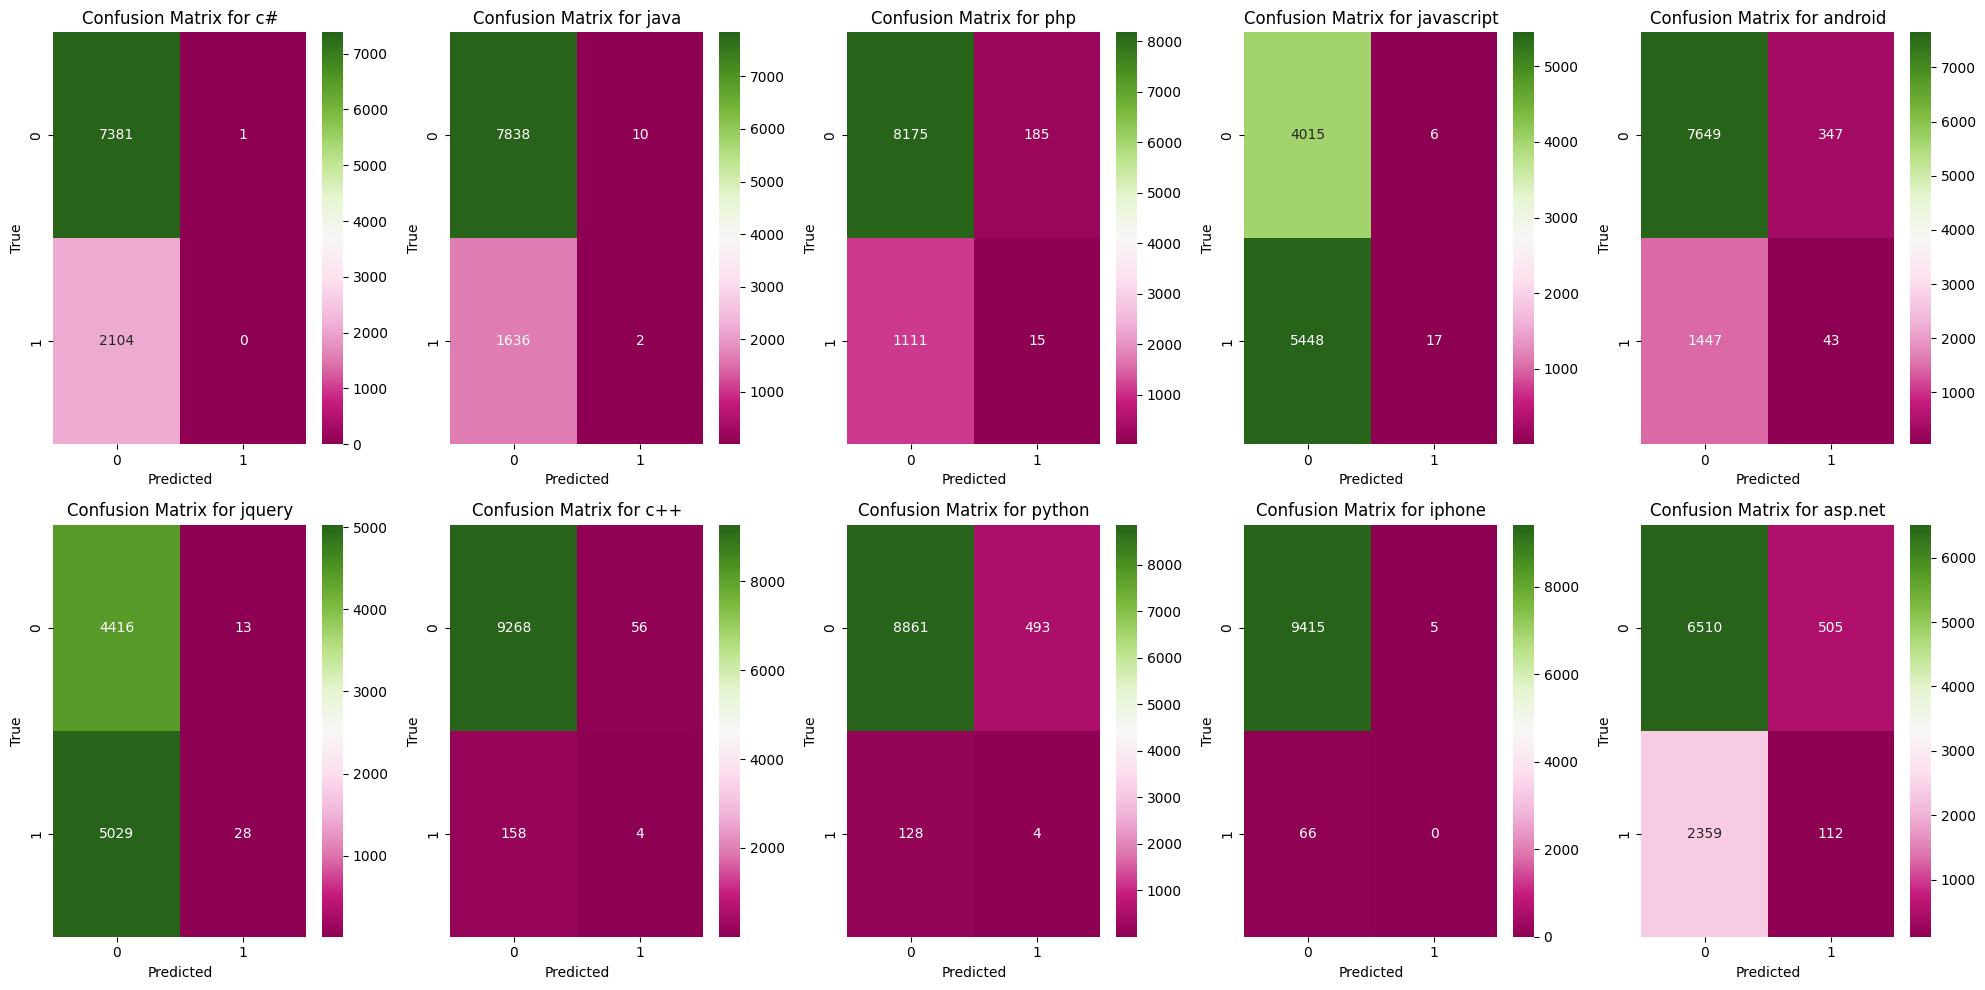

        Class  Precision    Recall  F1 Score
0          c#   0.000000  0.000000  0.000000
1        java   0.166667  0.001221  0.002424
2         php   0.075000  0.013321  0.022624
3  javascript   0.739130  0.003111  0.006195
4     android   0.110256  0.028859  0.045745
5      jquery   0.682927  0.005537  0.010985
6         c++   0.066667  0.024691  0.036036
7      python   0.008048  0.030303  0.012719
8      iphone   0.000000  0.000000  0.000000
9     asp.net   0.181524  0.045326  0.072539


In [ ]:
# Getting the predicitions
predictions_test, labels_test, avg_test_hamming_distance = get_hamming_distance_pred(test_loader, trained_model_sparse_stack, device)

# Printing the hamming distance
print(f"Average Hamming Distance on testing set: {avg_test_hamming_distance:.4f}")

# Example usage (after running your model and getting predictions)
class_labels = ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net']

# Plot the confusion matrices
plot_multilabel_confusion_matrix(labels_test, predictions_test, class_labels)
# Assuming y_true and y_pred contain your true labels and predicted labels as tensors
result_table = compute_metrics(labels_test, predictions_test, class_labels)

# Print the table
import pandas as pd
df = pd.DataFrame(result_table, columns=["Class", "Precision", "Recall", "F1 Score"])
print(df)


###  <font color = 'hotpink'>**Hamming Distance:**
- The **average Hamming distance** matches a similar result from the validation predictions indicating that roughly 22.3% of labels were incorrectly selected.

### <font color = 'hotpink'>**Precision, Recall and F1**
- These metrics are there just for reference among the different labels.


# <font color = 'hotpink'>**Inference Pipeline**</font>



In [ ]:
sample_X = X_test[0:5]

In [ ]:
# Preprocessing the input
sample_X = X_test[0:5]
device = 'cpu'

# Move model to the appropriate device
trained_model_sparse_stack.to(device)

sample_X_tensor = torch.tensor(sample_X.toarray(),dtype = torch.float32).to(device)
# Put model in evaluation mode
trained_model_sparse_stack.eval()

# Get outputs (logits) from the model
with torch.no_grad():
    outputs = trained_model_sparse_stack(sample_X_tensor)

# For multilabel classification, apply a threshold to determine class labels
predictions = (outputs > 0.5).float()  # Convert logits to binary predictions

# Define the mapping for class labels
class_labels = ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net']

# Get predicted labels for each sample
predicted_label_names = []
for sample_pred in predictions:
    predicted_classes = [class_labels[i] for i in range(len(class_labels)) if sample_pred[i] == 1]
    predicted_label_names.append(predicted_classes)

# Print the predicted labels for each sample
for i, label_names in enumerate(predicted_label_names):
    print(f"Sample {i+1}: {label_names}")


Sample 1: []
Sample 2: []
Sample 3: []
Sample 4: []
Sample 5: ['javascript', 'asp.net']


## <font color = 'hotpink'>**Final Thoughts**

- Above we can see that similarly how the confusion matrix showed instances of no label being predicted across multiple label types, this inference shows us no predicted labels for four of the documents.
- This is an extremely different outcome than that of the dense embeddings model where we obtained predictions for all of the documents in the sample.
- This is clearly because dense embeddings capture contextual meaning and relationships between words, leading to broader and more accurate predictions across documents.
- This is not a model we would want to use when classifying the semantic contents of bodies of text.
- This concludes my exercise in building MLP models using both dense and pretrained sparse embeddings.